# 1. Processing the data

In [3]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from matplotlib import image
from matplotlib import pyplot as plt
import os
import pandas as pd
from tensorflow import keras

# The batch size we'll use for training
batch_size = 64

# Size of the image required to train our model
img_size = 120

# These many images will be used from the data archive
dataset_split = 2500

master_dir = 'data'
x = []
y = []
for image_file in os.listdir( master_dir )[ 0 : dataset_split ]:
    rgb_image = Image.open( os.path.join( master_dir , image_file ) ).resize( ( img_size , img_size ) )
    # Normalize the RGB image array
    rgb_img_array = (np.asarray( rgb_image ) ) / 255
    gray_image = rgb_image.convert( 'L' )
    # Normalize the grayscale image array
    gray_img_array = ( np.asarray( gray_image ).reshape( ( img_size , img_size , 1 ) ) ) / 255
    # Append both the image arrays
    x.append( gray_img_array )
    y.append( rgb_img_array )

# Train-test splitting
train_x, test_x, train_y, test_y = train_test_split( np.array(x) , np.array(y) , test_size=0.1 )

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices( ( train_x , train_y ) )
dataset = dataset.batch( batch_size )


# 2. GAN Model 
            A Generative Adversarial Network (GAN) is a type of machine learning model composed of two neural networks, a generator and a discriminator, trained adversarially to generate realistic data samples, in this case, converting black and white images to color images.

# A. Generator 
            The generator aims to generate realistic color images from grayscale input images.

In [4]:
def get_generator_model():

    inputs = tf.keras.layers.Input( shape=( img_size , img_size , 1 ) )

    conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )
    return model


# B. Discriminator 
            The discriminator is used to distinguish between real and generated images.

In [5]:
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 120 , 120 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' )
    ]
    model = tf.keras.models.Sequential( layers )
    return model


# C. Loss Functions
            We'll now implement the loss functions for our GAN model. As you might know that we have two loss functions, one for the generator and another for the discriminator.

            For our generator, we'll use the L2/MSE loss function. For optimization, we use the Adam optimizer with a learning rate of 0.0005

In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator = get_generator_model()
discriminator = get_discriminator_model()


# 3. Training The GAN

In [7]:
@tf.function
def train_step( input_x , real_y ):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)

        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )

    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [8]:
num_epochs = 100

for e in range( num_epochs ):
    print( e )    for ( x , y ) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        print( x.shape )
        train_step( x , y )

0
(64, 120, 120, 1)
(26, 120, 120, 1)
1
(64, 120, 120, 1)
(26, 120, 120, 1)
2
(64, 120, 120, 1)
(26, 120, 120, 1)
3
(64, 120, 120, 1)
(26, 120, 120, 1)
4
(64, 120, 120, 1)
(26, 120, 120, 1)
5
(64, 120, 120, 1)
(26, 120, 120, 1)
6
(64, 120, 120, 1)
(26, 120, 120, 1)
7
(64, 120, 120, 1)
(26, 120, 120, 1)
8
(64, 120, 120, 1)
(26, 120, 120, 1)
9
(64, 120, 120, 1)
(26, 120, 120, 1)
10
(64, 120, 120, 1)
(26, 120, 120, 1)
11
(64, 120, 120, 1)
(26, 120, 120, 1)
12
(64, 120, 120, 1)
(26, 120, 120, 1)
13
(64, 120, 120, 1)
(26, 120, 120, 1)
14
(64, 120, 120, 1)
(26, 120, 120, 1)
15
(64, 120, 120, 1)
(26, 120, 120, 1)
16
(64, 120, 120, 1)
(26, 120, 120, 1)
17
(64, 120, 120, 1)
(26, 120, 120, 1)
18
(64, 120, 120, 1)
(26, 120, 120, 1)
19
(64, 120, 120, 1)
(26, 120, 120, 1)
20
(64, 120, 120, 1)
(26, 120, 120, 1)
21
(64, 120, 120, 1)
(26, 120, 120, 1)
22
(64, 120, 120, 1)
(26, 120, 120, 1)
23
(64, 120, 120, 1)
(26, 120, 120, 1)
24
(64, 120, 120, 1)
(26, 120, 120, 1)
25
(64, 120, 120, 1)
(26, 120, 120,

# 4. Results

In [9]:
y = generator( test_x[0 : ] ).numpy()

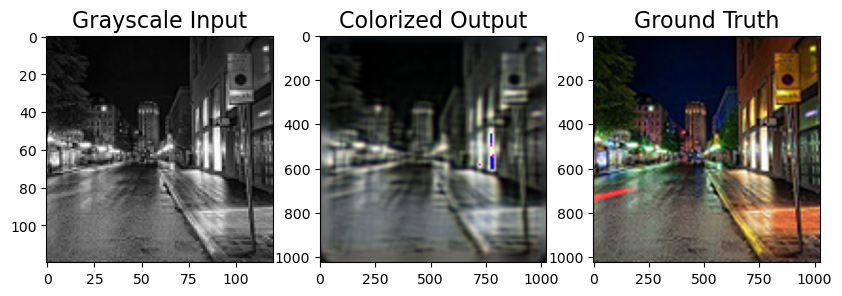

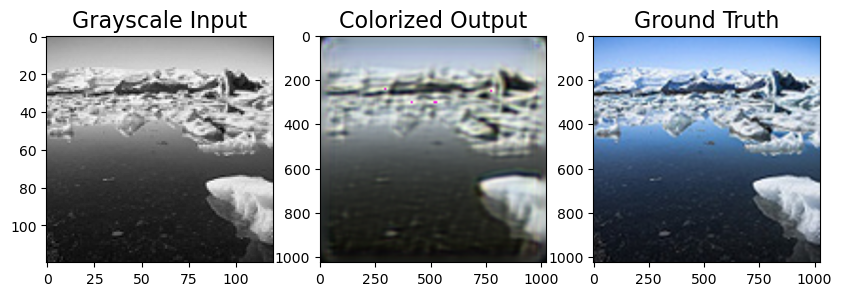

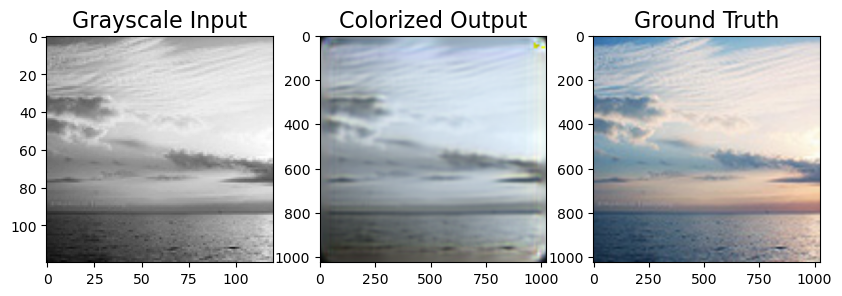

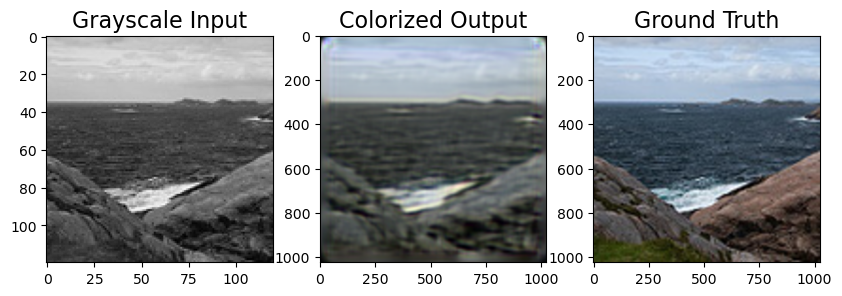

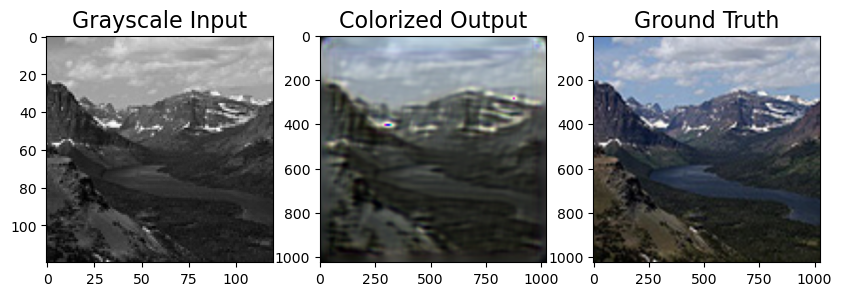

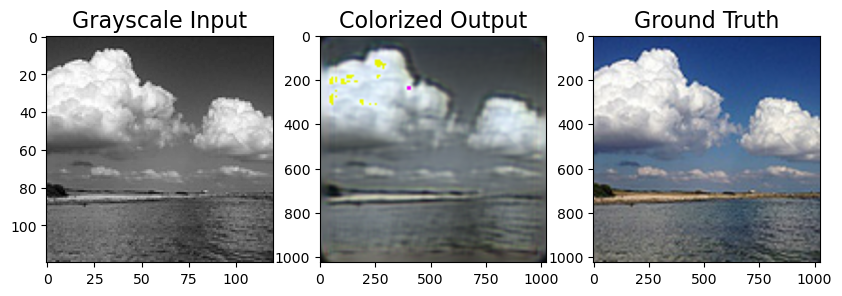

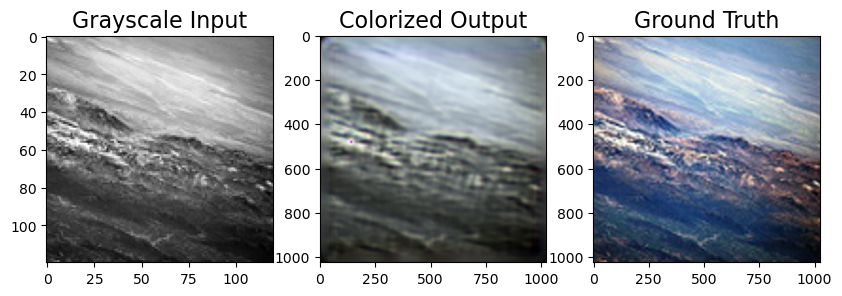

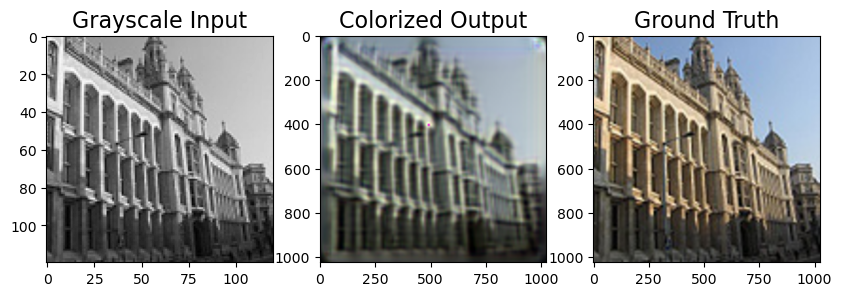

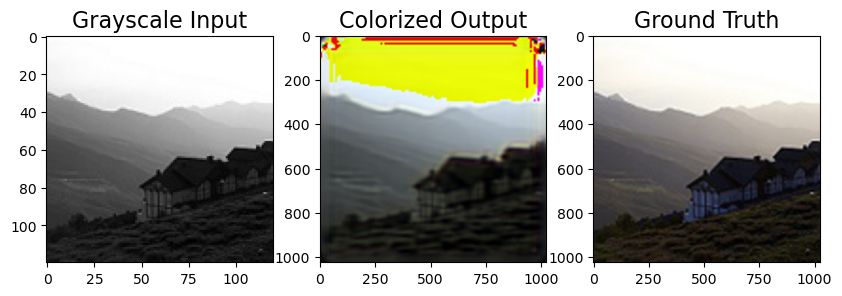

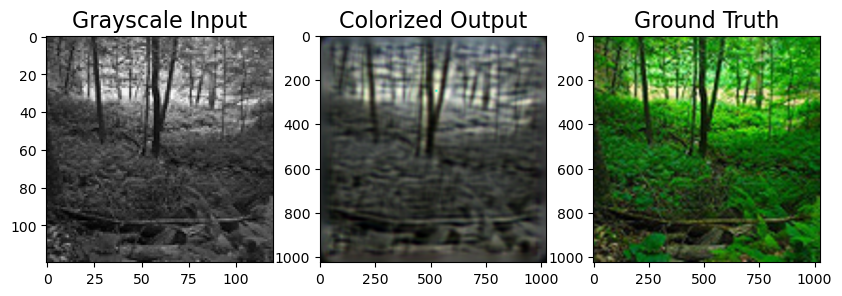

In [10]:
for i in range(len(test_x)):
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow( test_x[i].reshape((120,120)) , cmap='gray' )

  in_image = plt.subplot(3,3,2)
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )

  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )

  plt.show()

# 5. Testing

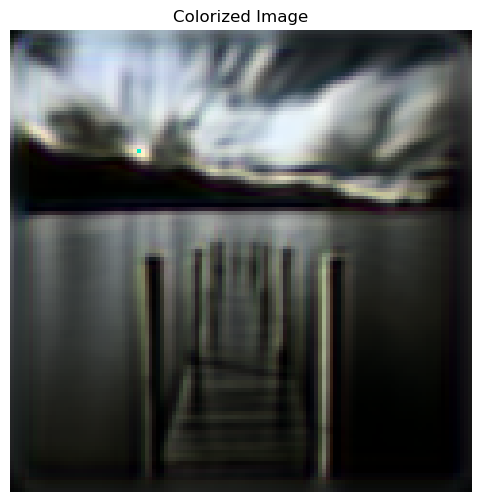

In [11]:
def colorize_image(input_image_path):
    # Load the color image
    color_image = Image.open(input_image_path).convert('RGB')
    color_image_resized = color_image.resize((img_size, img_size))

    # Convert color image to grayscale
    gray_image = color_image_resized.convert('L')

    # Normalize the grayscale image array
    gray_img_array = (np.asarray(gray_image) / 255).reshape((1, img_size, img_size, 1))

    # Generate colorized image using the generator model
    colorized_image = generator(gray_img_array).numpy()[0]

    # Rescale the colorized image to 0-255 range
    colorized_image_rescaled = (colorized_image * 255).astype('uint8')

    # Display the colorized image
    plt.figure(figsize=(6, 6))
    plt.imshow(colorized_image_rescaled)
    plt.axis('off')
    plt.title('Colorized Image')
    plt.show()

# Example usage:
# Provide the path to your color image
input_image_path = 'C:/Users/User/OneDrive/Documents/Banu_Project/test.jpg'
colorize_image(input_image_path)


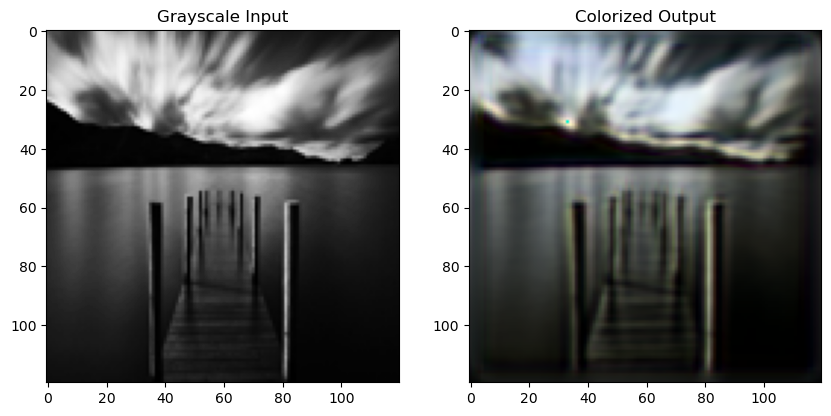

In [12]:
def preprocess_image(image_path, img_size):
    # Load the image in grayscale
    grayscale_image = Image.open(image_path).convert('L')
    # Resize the image
    resized_image = grayscale_image.resize((img_size, img_size))
    # Normalize and reshape the image
    normalized_image = np.asarray(resized_image) / 255.0
    normalized_image = normalized_image.reshape((1, img_size, img_size, 1))
    return normalized_image

def colorize_image(grayscale_image):
    # Generate colorized output using thee gnerator model
    colorized_output = generator(grayscale_image, training=False).numpy()
    # Denormalize the colorized output
    colorized_output = (colorized_output * 255).astype('uint8')
    return colorized_output

# Example usage:
input_image_path = 'C:/Users/User/OneDrive/Documents/Banu_Project/test.jpg'
# Preprocess the input image
input_image = preprocess_image(input_image_path, img_size)
# Colorize the input image
output_image = colorize_image(input_image)

# Plot the original grayscale image and colorized output
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Grayscale Input')
plt.imshow(input_image.reshape((img_size, img_size)), cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Colorized Output')
plt.imshow(output_image.reshape((img_size, img_size, 3)))
plt.show()


# Output

# 6.Accuracy

In [15]:
def evaluate_model(test_x, test_y, generator):
    y_pred = generator(test_x).numpy()

    # Calculate Mean Squared Error (MSE)
    mse = np.mean(np.square(test_y - y_pred))

    # Calculate Peak Signal-to-Noise Ratio (PSNR)
    psnr = tf.image.psnr(test_y, y_pred, max_val=1.0).numpy()

    return mse, psnr


In [16]:
# Evaluate the model
mse, psnr = evaluate_model(test_x, test_y, generator)
print("Mean Squared Error (MSE):", mse)
print("Peak Signal-to-Noise Ratio (PSNR):", psnr)


Mean Squared Error (MSE): 0.2623750700987338
Peak Signal-to-Noise Ratio (PSNR): [ 9.230415   5.195382   3.1830068  6.09934    7.438672   5.5965996
  5.42254    5.7721186  4.2161613 10.475541 ]
